In [1]:
import sys
import os
import argparse
import pickle
from typing import Optional
from collections import defaultdict
from collections import namedtuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from venn import venn, pseudovenn

import shap

import sklearn
from sklearn.metrics import brier_score_loss, roc_auc_score
from tqdm import tqdm

# PROJECT
ROOT_PATH = '/home/karina/ehr_ood_detection/'
sys.path.append(ROOT_PATH)

from src.models.info import AVAILABLE_MODELS
from src.utils.model_init import init_models
from src.utils.novelty_analyzer import NoveltyAnalyzer
from src.models.info import (
    NEURAL_PREDICTORS,
    DISCRIMINATOR_BASELINES,
    DEEP_KERNELS
)
from src.utils.datahandler import load_data_from_origin, DataHandler
from src.utils.metrics import (
    ece,
    accuracy,
    nll,
)

from src.utils.scoreshandler import NoveltyScoresHandler
from src.utils.datahandler import load_data_from_origin, DataHandler

TABLES_DIR = os.path.join(ROOT_PATH, "data/novelty_tables")
RESULT_DIR = os.path.join(ROOT_PATH, "data/results")
DATA_ORIGIN = "VUmc"

## Load data and novelty scores

In [2]:
# Define for compatibility with the IDE functions
Args = namedtuple("Args", 'data_origin, result_dir')
args = Args(DATA_ORIGIN, RESULT_DIR)

In [3]:
# Load targets
sh = NoveltyScoresHandler(args.data_origin, args.result_dir)
scores_test = sh._get_scores(result_type = 'test')
scores_train = sh._get_scores(result_type = 'train')

In [4]:
# Load features
data_loader = load_data_from_origin(args.data_origin)
dh = DataHandler(**data_loader)
X_train, _, X_test, _, _, _ = dh.get_processed_data(scale=True)
X_test.head()

,age,alat__first__overall,alat__is_measured__first_24h,alat__is_measured__last_24h,alat__is_measured__overall,alat__last__overall,alat__maximum__first_24h,alat__maximum__last_24h,alat__maximum__overall,alat__mean__first_24h,...,weight__mean__first_24h,weight__mean__last_24h,weight__mean__overall,weight__mean__overall__diff,weight__minimum__first_24h,weight__minimum__last_24h,weight__minimum__overall,weight__standard_deviation__first_24h,weight__standard_deviation__last_24h,weight__standard_deviation__overall
12776,0.208338,-2.571594e-17,-0.836748,-0.564198,-1.005234,1.341701e-17,-2.115117e-17,-1.396415e-17,1.900744e-17,-6.140661e-18,...,-0.592510,-6.437533e-17,-0.599947,-9.289658e-18,-0.571143,2.327858e-16,-0.566624,-0.124656,-8.046917e-18,-0.175002
8728,-1.841463,1.497769e-01,-0.836748,-0.564198,0.994794,1.903120e-01,-2.115117e-17,-1.396415e-17,-2.725539e-02,-6.140661e-18,...,0.632517,-6.437533e-17,0.619133,-9.289658e-18,0.664125,2.327858e-16,0.667501,-0.174363,-8.046917e-18,-0.219490
10988,1.234953,1.815384e-01,1.195102,-0.564198,0.994794,-1.107904e-01,5.204464e-02,-1.396415e-17,1.991159e-01,6.813280e-02,...,-0.594964,-6.437533e-17,-0.602390,-9.289658e-18,-0.571143,2.327858e-16,-0.566624,-0.174363,-8.046917e-18,-0.219490
6797,-0.061668,-2.571594e-17,-0.836748,-0.564198,-1.005234,1.341701e-17,-2.115117e-17,-1.396415e-17,1.900744e-17,-6.140661e-18,...,1.798624,1.786848e+00,1.779579,-2.300083e-03,1.837631,1.807144e+00,1.839919,-0.174363,-1.071439e-01,-0.219490
9590,-1.586001,-2.571594e-17,-0.836748,-0.564198,-1.005234,1.341701e-17,-2.115117e-17,-1.396415e-17,1.900744e-17,-6.140661e-18,...,-1.951331,-6.437533e-17,-1.950645,-9.289658e-18,-1.948468,2.327858e-16,-1.942673,-0.115783,-8.046917e-18,-0.171330


###  Regression models for SHAP values

In [5]:
import xgboost

def train_regressor(X: np.ndarray,
                    y: np.ndarray,
                    X_test: Optional[np.ndarray] = None,
                    y_test: Optional[np.ndarray] = None,
                    model_name: [str] = None,
                    regressor: str = "xgboost"):
    """
    Trains a regression model to learn uncertainty scores from a model using one of the available regressors.
    
    Parameters
    ----------
    X: np.ndarray
    y: np.ndarray
    X_test: np.ndarray
    y_test: np.ndarray
    model_name: str
    regressor: str

    Returns
    -------
    reg: model instance
    """
    
    if regressor == "SGD":
        reg = sklearn.ensemble.GradientBoostingRegressor()
        
    elif regressor == "random_forest":
        reg = sklearn.ensemble.RandomForestRegressor(n_estimators=10)
        
    elif regressor == "xgboost":
        reg = xgboost.XGBRegressor()
    
    print(model_name,end='')
    reg.fit(X,y)
    
    if regressor in ["SGD", "random_forest"]:
        r2 = np.round(reg.score(X_test, y_test),2)
    else:
        y_pred = reg.predict(X_test)
        r2 = np.round(sklearn.metrics.r2_score(y_test,y_pred),2)
        
    print("\tR^2=", r2)
    
    return reg

In [6]:
def plot_shap_values(regressors: dict,
                     X_df: pd.DataFrame,
                     uncertain_index: Optional[int] = None,
                     certain_index: Optional[int] = None):
    """
    Parameters
    regressors: dict
        Dictionary of regression models.
    X_df: pd.DataFrame
        Dataframe with features to be exlpained (test dataset).
    uncertain_index: int
        Index of a sample to be plotted.
    certain_index: int
        Index of a sample to be plotted.
        
    """
    for key, model in regressors.items():
        print(key)

        explainer = shap.Explainer(model)
   
        if uncertain_index and certain_index:
            shap_values = explainer(X_df.loc[[uncertain_index,certain_index]])
            print("\tUncertain sample:")
            shap.plots.waterfall(shap_values[0])
            print("\tCertain sample:")
            shap.plots.waterfall(shap_values[1])

In [21]:
regressor = "xgboost"
estim_cols = ["AE (reconstr err)", "DUE (entropy)","DUE (std)", "LOF (outlier score)", "PPCA (log prob)",
             "VAE (latent prior prob)", "VAE (latent prob)","VAE (reconstr err grad)"]

X = X_test.values

regressors = dict()

for i,col in enumerate(estim_cols):
    y_train = scores_train[col].values
    y_test = scores_test[col].values
    
    reg = train_regressor(X_train.values,
                          y_train,
                          X_test.values,
                          y_test,
                          model_name = col, 
                          regressor = regressor)
    
    regressors[col] = reg

AE (reconstr err)	R^2= 0.79
DUE (entropy)	R^2= 0.84
DUE (std)	R^2= 0.8
LOF (outlier score)	R^2= 0.48
PPCA (log prob)	R^2= 0.58
VAE (latent prior prob)	R^2= 0.69
VAE (latent prob)	R^2= 0.48
VAE (reconstr err grad)	R^2= 0.32


In [23]:
# Create a dataset with nice feature names to display in graphs
X_test_display = X_test.copy()
X_test_display.columns = list(map(lambda x: x.replace('_', ' '), X_test.columns))

AE (reconstr err)
	Uncertain sample:


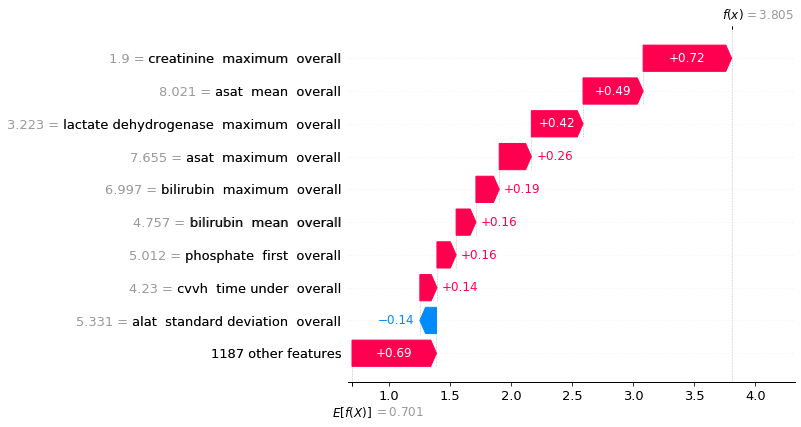

	Certain sample:


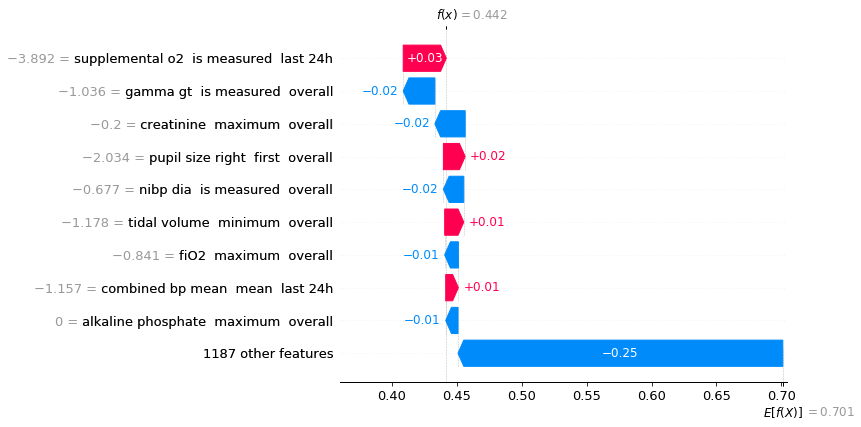

DUE (entropy)
	Uncertain sample:


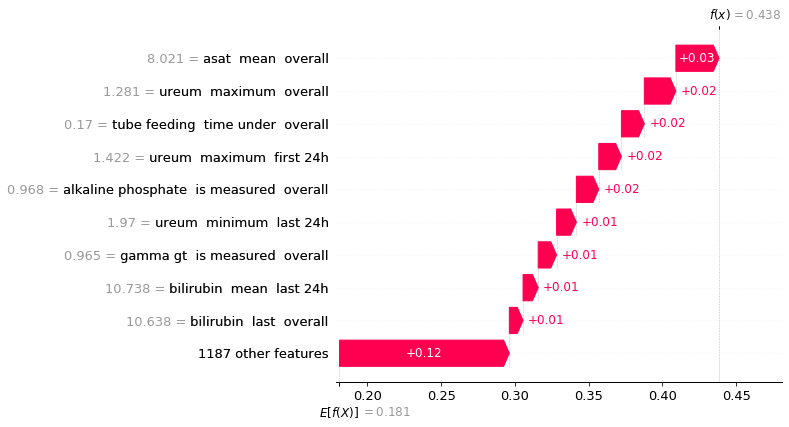

	Certain sample:


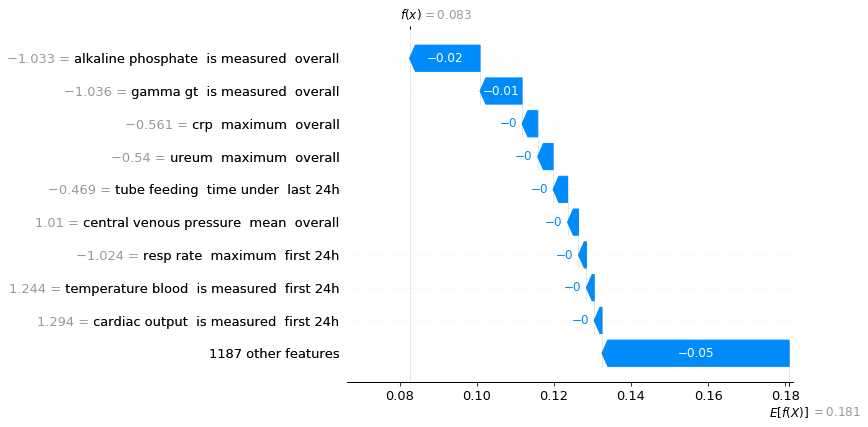

DUE (std)
	Uncertain sample:


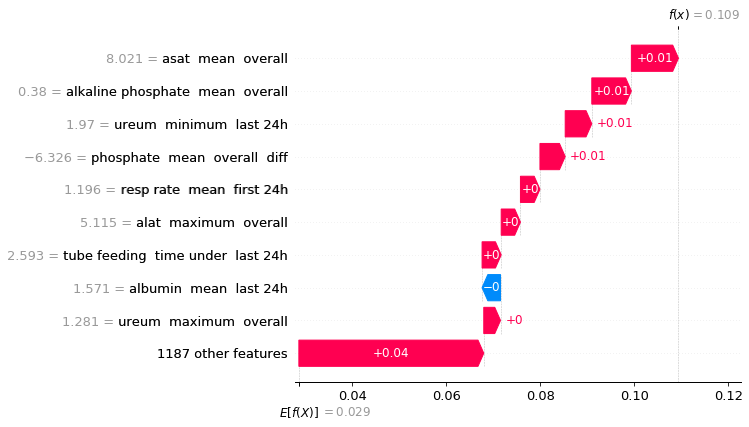

	Certain sample:


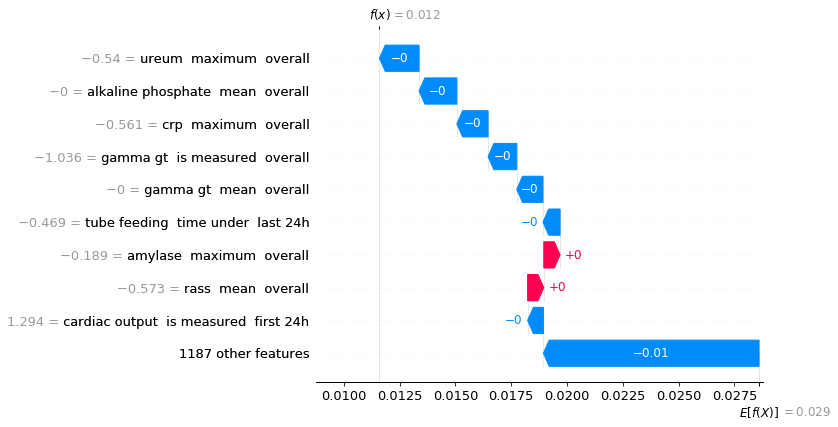

LOF (outlier score)
	Uncertain sample:


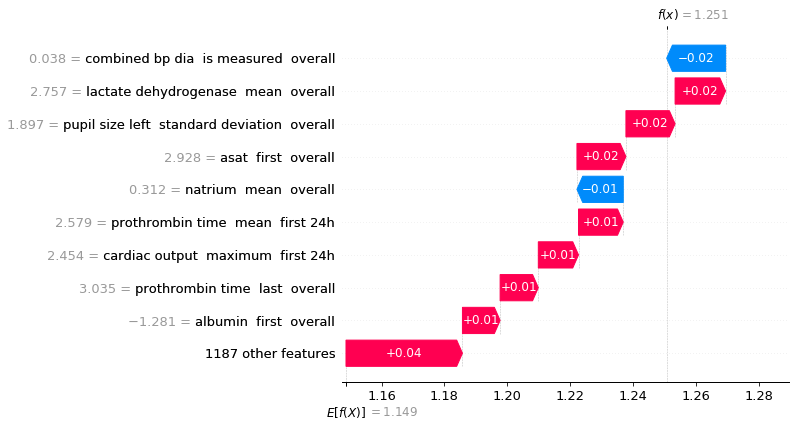

	Certain sample:


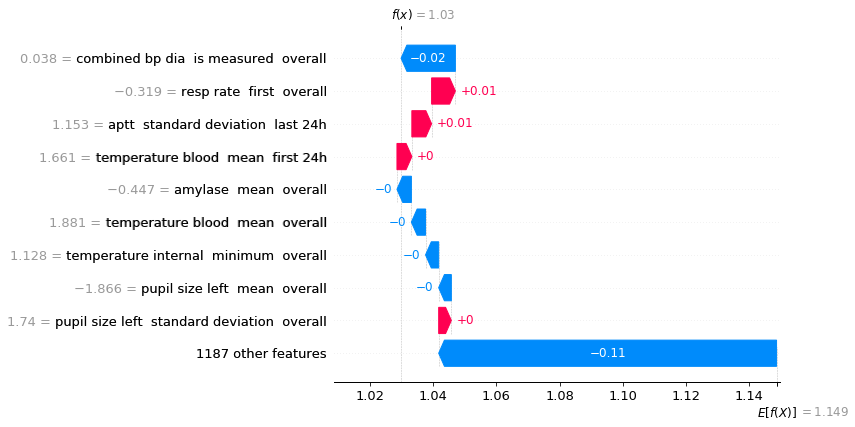

PPCA (log prob)
	Uncertain sample:


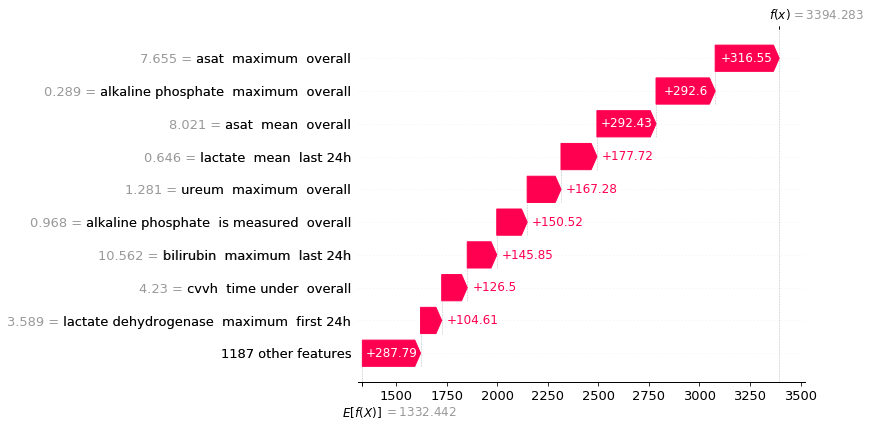

	Certain sample:


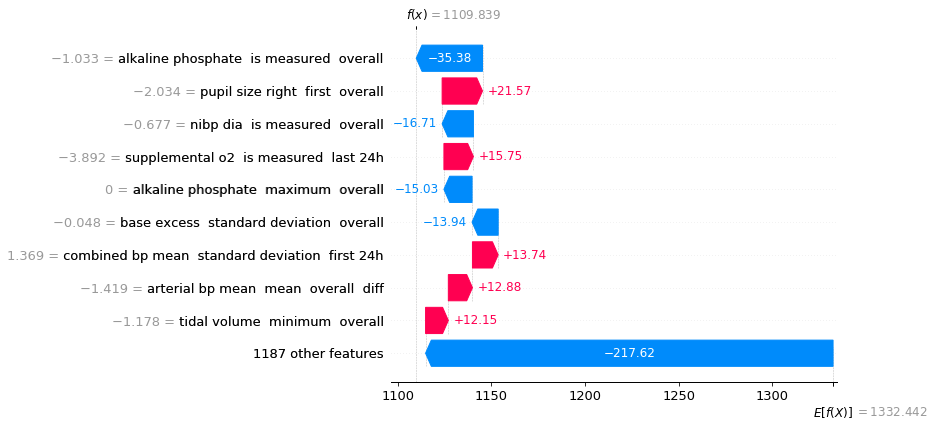

VAE (latent prior prob)
	Uncertain sample:


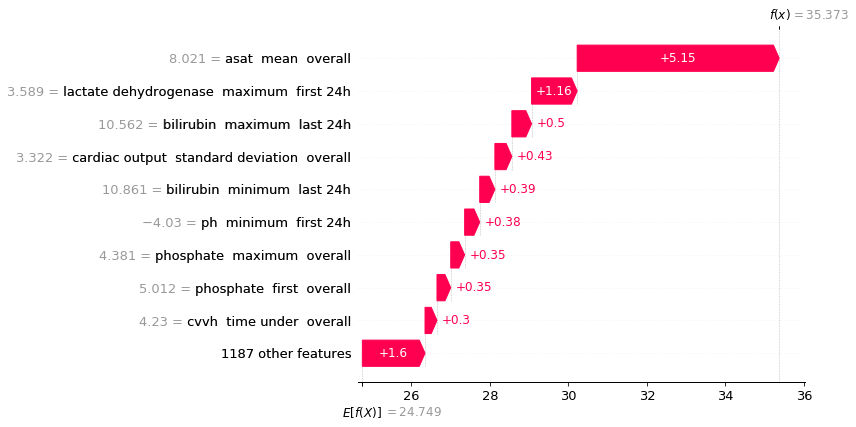

	Certain sample:


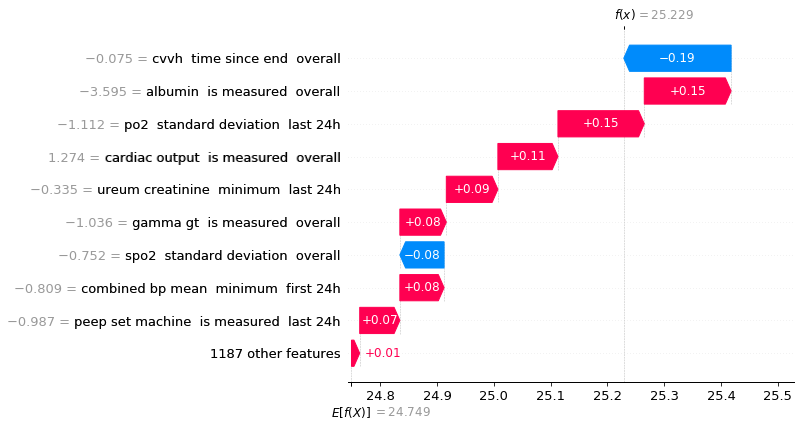

VAE (latent prob)
	Uncertain sample:


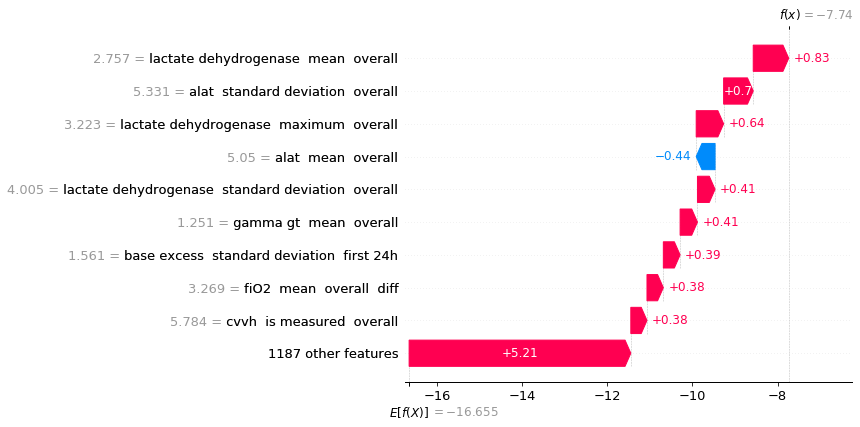

	Certain sample:


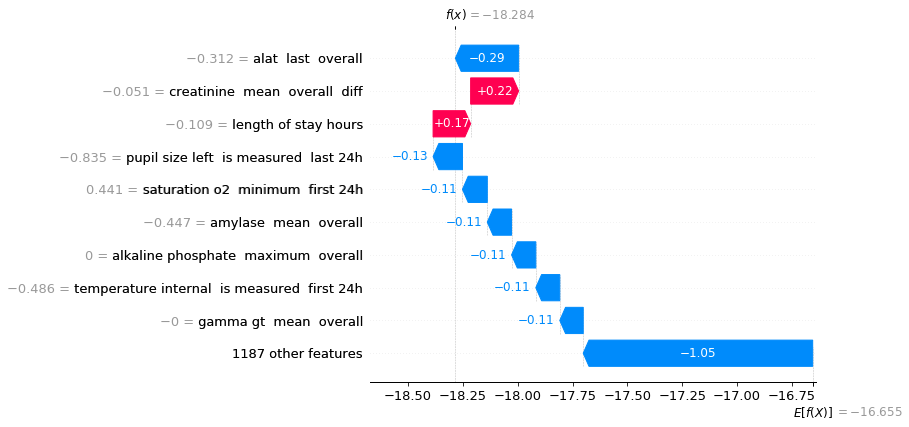

VAE (reconstr err grad)
	Uncertain sample:


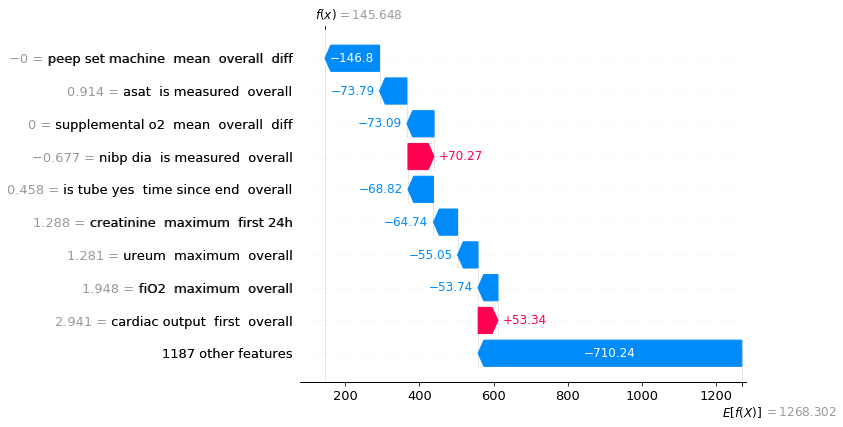

	Certain sample:


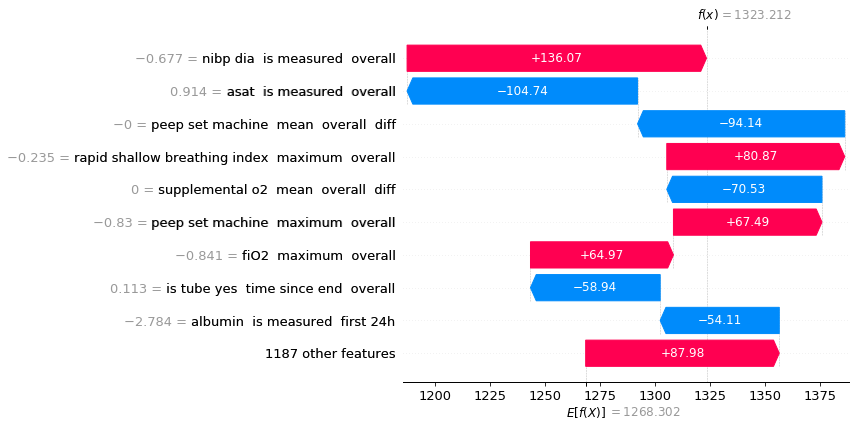

In [25]:
plot_shap_values(regressors, X_test_display, 191, 15941)

### Autoencoders reconstruction error

In [7]:
recontr_err = pd.read_csv(os.path.join(ROOT_PATH, "data/novelty_tables/VUmc/AE_reconstr_test.csv"), index_col=0)

In [77]:
INDEX = 191
column = "AE (reconstr err)"

print('AE reconstruction error on train data')
print('\t median: \t\t', np.round(float(scores_train[[column]].median()),2))
print('\t 95% percentile: \t', np.round ( float(scores_train[[column]].quantile(.95)),2))

print('Uncertain sample')
print('\t index:', INDEX)
print('\t reconstruction error: ', np.round(float(scores_test[[column]].loc[index]),2))

AE reconstruction error on train data
	 median: 		 0.55
	 95% percentile: 	 1.45
Uncertain sample
	 index: 191
	 reconstruction error:  2.31


In [64]:
bad_rec_ = recontr_err.loc[[INDEX]].values
bad_ = X_test.loc[[INDEX]].values

bad = pd.DataFrame(np.array([bad_, bad_rec_]).reshape(2,-1).T, 
                   index = X_test.columns,
                   columns = [f'ind{INDEX}', f'ind{INDEX}_rec'])

bad['ind191_absdiff'] = np.abs(bad[f'ind{INDEX}']-bad[f'ind{INDEX}_rec'])

In [76]:
bad.sort_values(by = 'ind191_absdiff',ascending=False)[:10]

,ind191,ind191_rec,ind191_absdiff
bilirubin__mean__overall__diff,15.728031,0.007096,15.720934
asat__mean__overall__diff,-11.806875,0.002437,11.809312
bilirubin__minimum__last_24h,10.860599,0.878761,9.981838
bilirubin__mean__last_24h,10.737925,0.886849,9.851076
bilirubin__last__overall,10.638380,0.945828,9.692552
bilirubin__maximum__last_24h,10.561976,0.877627,9.684349
bilirubin__standard_deviation__overall,10.018424,0.940595,9.077829
asat__maximum__first_24h,9.162716,0.994609,8.168107
asat__mean__first_24h,8.476599,0.996168,7.480431
asat__standard_deviation__overall,8.456689,0.991785,7.464904


### VAE reconstruction error

In [78]:
recontr_err = pd.read_csv(os.path.join(ROOT_PATH, "data/novelty_tables/VUmc/VAE_reconstr_test.csv"), index_col=0)

In [80]:
INDEX = 191
model = "VAE"
column = "VAE (reconstr err)"

print(f'{model} reconstruction error on train data')
print('\t median: \t\t', np.round(float(scores_train[[column]].median()),2))
print('\t 95% percentile: \t', np.round ( float(scores_train[[column]].quantile(.95)),2))

print('Uncertain sample')
print('\t index:', INDEX)
print('\t reconstruction error: ', np.round(float(scores_test[[column]].loc[index]),2))

VAE reconstruction error on train data
	 median: 		 453.43
	 95% percentile: 	 1277.85
Uncertain sample
	 index: 191
	 reconstruction error:  1558.37


In [82]:
bad_rec_ = recontr_err.loc[[INDEX]].values
bad_ = X_test.loc[[INDEX]].values

bad = pd.DataFrame(np.array([bad_, bad_rec_]).reshape(2,-1).T, 
                   index = X_test.columns,
                   columns = [f'ind{INDEX}', f'ind{INDEX}_rec'])

bad['ind191_absdiff'] = np.abs(bad[f'ind{INDEX}']-bad[f'ind{INDEX}_rec'])

In [83]:
bad.sort_values(by = 'ind191_absdiff',ascending=False)[:10]

,ind191,ind191_rec,ind191_absdiff
cvvh__is_measured__overall,5.783798,-13.178198,18.961996
bilirubin__mean__overall__diff,15.728031,-0.788428,16.516458
bilirubin__last__overall,10.638380,-2.361576,12.999955
bilirubin__maximum__last_24h,10.561976,-2.323853,12.885829
asat__mean__overall__diff,-11.806875,0.517485,12.324360
cvvh__is_measured__first_24h,8.053208,-3.840814,11.894023
bilirubin__standard_deviation__overall,10.018424,-1.684854,11.703278
bilirubin__minimum__last_24h,10.860599,0.504458,10.356141
asat__standard_deviation__overall,8.456689,-0.786767,9.243457
bilirubin__mean__last_24h,10.737925,2.591939,8.145985
